In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose

import matplotlib.pyplot as plt

import sys

import numpy as np

img_rows=28
img_cols=28
channels=1
#dimensions of the input image
img_shape=(img_rows,img_cols,channels)
latent_dim= 100 #noise vector size


Generator Architecture

In [2]:
def build_generator(img_shape, latent_dim):

        model = Sequential()
        # Fully Connected three layers with Leaky ReLU activation and Batch normalization
        model.add(Dense(256, input_dim=latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        # Output Layer with tanh activation
        model.add(Dense(np.prod(img_shape), activation='tanh'))
        # Reshape the generator output to image dimensions
        model.add(Reshape(img_shape))

        model.summary()

        noise = Input(shape=(latent_dim,))
        img = model(noise)

        return Model(noise, img)

Discriminator Architecture

In [3]:
def build_discriminator(img_shape):
        model = Sequential()
        # Flatten the input image
        model.add(Flatten(input_shape=img_shape))
        # Fully connected two layers with Leaky ReLU activation function
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        # Output layer with sigmoid activation
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

Model Architecture

In [4]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.0002,0.5),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(img_shape, latent_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator and Discriminator model
    model.add(generator)
    model.add(discriminator)
    model.summary()
    
    return model

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trai

Training the Model

In [5]:
def sample_images(epoch,generator):
        rows, cols = 5, 5
        noise = np.random.normal(0, 1, (rows * cols, latent_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 pixel values to [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(rows, cols)
        cnt = 0
        for i in range(rows):
            for j in range(cols):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #plt.savefig("images/%d.png"%epoch)
        #plt.close()
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.close()

In [6]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(epochs, batch_size, sample_interval):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            # Generate a batch of new images
            gen_imgs = generator.predict(noise)

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(imgs, real)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = gan.train_on_batch(noise, real)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                      (epoch, d_loss[0], 100.0 * d_loss[1], g_loss))

            if (epoch + 1) % sample_interval == 0:

                # Save losses and accuracies so they can be plotted after training
                losses.append((d_loss[0], g_loss))
                accuracies.append(100.0 * d_loss[1])
                iteration_checkpoints.append(epoch + 1)

                
                # Output a sample of generated image
                sample_images(epoch+1, generator)

In [7]:
# Set hyperparameters
epochs = 20000
batch_size = 128
sample_interval = 500

# Train the GAN for the specified number of iterations
train(epochs, batch_size, sample_interval)

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 11ms/step
17503 [D loss: 0.675717, acc.: 55.86%] [G loss: 0.831078]
4/4 [==============================] - 0s 10ms/step
17504 [D loss: 0.685546, acc.: 57.03%] [G loss: 0.819522]
4/4 [==============================] - 0s 10ms/step
17505 [D loss: 0.669685, acc.: 57.03%] [G loss: 0.834809]
4/4 [==============================] - 0s 11ms/step
17506 [D loss: 0.631979, acc.: 62.89%] [G loss: 0.885910]
4/4 [==============================] - 0s 14ms/step
17507 [D loss: 0.683486, acc.: 62.50%] [G loss: 0.843212]
4/4 [==============================] - 0s 14ms/step
17508 [D loss: 0.667984, acc.: 58.20%] [G loss: 0.805934]
4/4 [==============================] - 0s 11ms/step
17509 [D loss: 0.650263, acc.: 67.97%] [G loss: 0.869411]
4/4 [==============================] - 0s 11ms/step
17510 [D loss: 0.664276, acc.: 57.03%] [G loss: 0.844816]
4/4 [==============================] - 0s 12ms/step
17511 [D loss: 0.

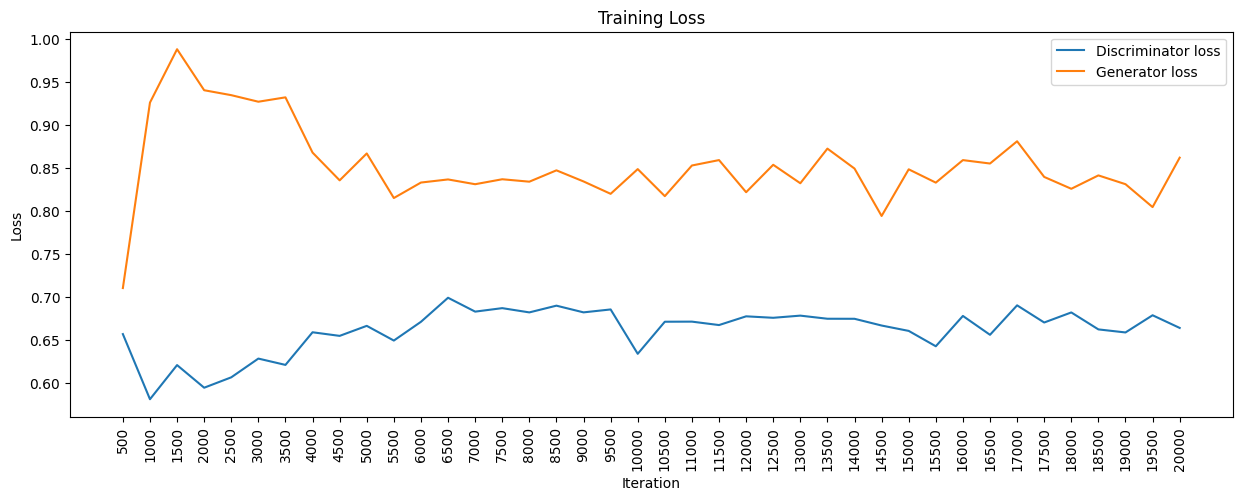

In [8]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

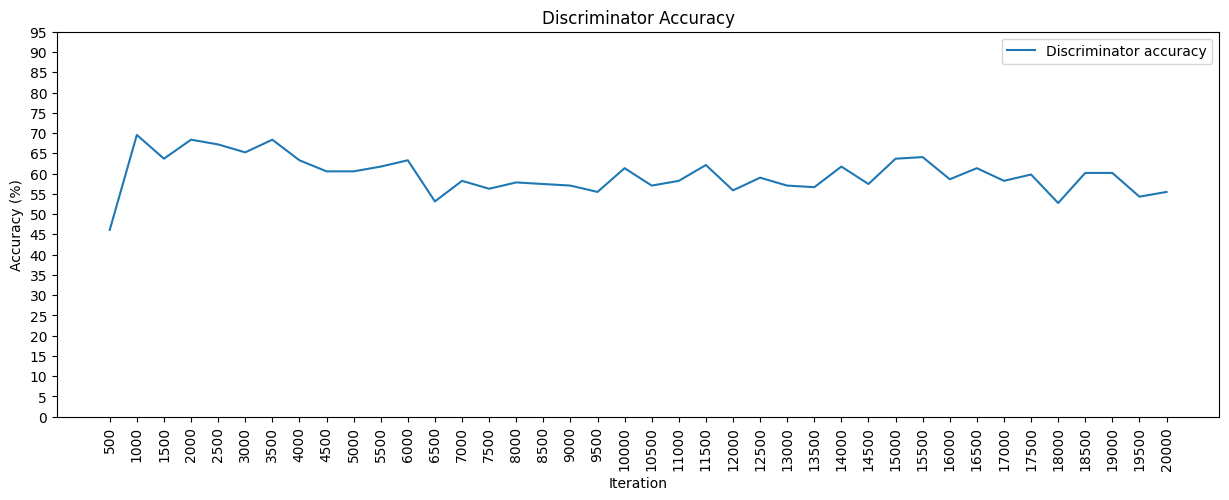

In [9]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()